# Weak discriminator boosting

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
from ROOT import *
from array import array

# For random number generation

from scipy.stats import norm
from scipy.stats import expon

# For plot
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 

### (2) Define generation procedure for normal and exponential distribution

In [3]:
# Normal distribution with correlation

def mynorm(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,3))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*cos(phi) + g[1]*sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*sin(phi) + g[1]*cos(phi))
    
    return data

# Exponential distribution with correlation

def myexpo(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,3))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*cos(phi) + g[1]*sin(phi)
    r2_tab = g[0]*sin(phi) + g[1]*cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (3) Generating training and test data

In [4]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Exponential background

h1 = np.array([-1.,-1.])
sig1 = np.array([2.0,2.0])
corr1 = 0.0

# H2: Normal distribution

h2 = np.array([1.,1.])
sig2 = np.array([0.3,0.3])
corr2 = 0.7

# Fraction of first hypothesis

fh1 = 0.5

# Generate train sample 
# ---------------------

h1train = myexpo(Ntrain,h1,sig1,corr1)
h2train = mynorm(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain > fh1

y2_train = np.resize(np.repeat(y_train,3),(Ntrain,3))

X_train = y2_train * h1train + (1 - y2_train)*h2train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = myexpo(Ntest,h1,sig1,corr1)
h2test = mynorm(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest > fh1

y2_test = np.resize(np.repeat(y_test,3),(Ntest,3))

X_test = y2_test * h1test + (1 - y2_test)*h2test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (4) Boost procedure

In [5]:
# Number of boost steps

Nboost = 1000

# Initial event weights

etab = 1.0/Ntrain * np.ones(shape=(Nboost,Ntrain))

# Boost factors

atab = np.empty(Nboost)

# Classifiers at each loop

wtab = np.zeros(shape=(Nboost,3))
    
# Random generations in each boost step

Ntry = 100

for ib in range(Nboost):
    
    # Apply event weights starting from the second loop
    
    if ib>0:
        ypred  = X_train @ wtab[ib-1,:]
#        etab[ib,:] = etab[ib-1,:]*((ypred*y_train <= 0)*(exp(atab[ib-1]) - 1.) + 1.)
        etab[ib,:] = etab[ib-1,:]*np.exp(-1.0*ypred*y_train*atab[ib-1])
        
        enorm = np.sum(etab[ib,:])
        etab[ib,:] /= enorm
        
        
    # Generate random weights and select best performing

    nbest = 0
    ebest = 1.0
    wbest = np.zeros(shape=3)

    for itry in range(Ntry):
        wvec = 2.*np.random.uniform(size=3)-1.
        ypred  = X_train @ wvec
        nok = np.sum(ypred*y_train > 0)
        
        werr = np.sum((ypred*y_train <= 0)*etab[ib,:])
        wall = np.sum(etab[ib,:])
        err = werr/wall

        if err>0.5:
            wvec *= -1.
            err = 1-err
            nok = Ntrain - nok
            
        if err < ebest:
            ebest = err
            wbest = wvec
            nbest = nok
        
    if ebest >= 0.5:
        print("Something wrong, error rate: ", ebest)
    
    # Weight for this loop
    wtab[ib,:] = wbest

    # Just in case, if perfect cut found:
    if ebest == 0: ebest = 1.0/Ntrain
    
    atab[ib] = log((1.0-ebest)/ebest)
    
    if ib<10 or (ib<100 and ib%10==9) or ib%100==99:
        print("Loop ",ib+1," : ",nok," events properly classified, weighted error rate ",ebest)
 

Loop  1  :  648  events properly classified, weighted error rate  0.2559999999999999
Loop  2  :  323  events properly classified, weighted error rate  0.003595182647284959
Loop  3  :  387  events properly classified, weighted error rate  2.614963317772524e-06
Loop  4  :  421  events properly classified, weighted error rate  4.156675004196586e-13
Loop  5  :  629  events properly classified, weighted error rate  0.001
Loop  6  :  427  events properly classified, weighted error rate  0.001
Loop  7  :  334  events properly classified, weighted error rate  0.001
Loop  8  :  372  events properly classified, weighted error rate  0.001
Loop  9  :  513  events properly classified, weighted error rate  0.001
Loop  10  :  428  events properly classified, weighted error rate  0.001
Loop  20  :  370  events properly classified, weighted error rate  0.001
Loop  30  :  350  events properly classified, weighted error rate  9.925271059005761e-13
Loop  40  :  262  events properly classified, weighted er

In [6]:
# Final classifier

ypred  = (2.0*( X_train @ np.transpose(wtab) > 0.0)-1.0) @ atab / Nboost 
            
ycut = np.median(ypred)

nok = np.sum((ypred-ycut)*y_train > 0)

err = 1.0 - nok/Ntrain

print("Combined : ",nok," events properly classified, error rate ",err)

Combined :  947  events properly classified, error rate  0.05300000000000005


### (5) Plot results

In [7]:
# Square plot

gStyle.SetCanvasDefW(900)
gStyle.SetCanvasDefH(600)
 
# Create plot canvas

cexp = TCanvas('cexp')
   
# Create data graph - train data

tgr = TGraph(y_train.size,array('d',X_train[:,0]),array('d',X_train[:,1]))

# Set graph options

tgr.SetNameTitle("tgr","Linear discriminant - percepton learning")
tgr.SetMarkerStyle(20)
tgr.SetMarkerSize(0.7)
tgr.SetMarkerColor(2)

tgr.GetXaxis().SetTitle("x_{1}")
tgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

nt1 = np.sum(y_train==1)

Xt1 = np.zeros(shape=(nt1,3))

it1 = 0
for ip in range(y_train.size):
    if y_train[ip]==1 :
        Xt1[it1]=X_train[ip]
        it1+=1
             
tgr1 = TGraph(int(nt1),array('d',Xt1[:,0]),array('d',Xt1[:,1]))

# Set graph options

tgr1.SetNameTitle("tgr1","Train data")
tgr1.SetMarkerStyle(20)
tgr1.SetMarkerSize(0.7)
tgr1.SetMarkerColor(3)
    
# Create data graph - test data

rgr = TGraph(y_test.size,array('d',X_test[:,0]),array('d',X_test[:,1]))

# Set graph options

rgr.SetNameTitle("rgr","Linear discriminant - single percepton learning")
rgr.SetMarkerStyle(20)
rgr.SetMarkerSize(0.7)
rgr.SetMarkerColor(2)

rgr.GetXaxis().SetTitle("x_{1}")
rgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

n1 = np.sum(y_test==1)

X1 = np.zeros(shape=(n1,3))

ip1 = 0
for ip in range(y_test.size):
    if y_test[ip]==1 :
        X1[ip1]=X_test[ip]
        ip1+=1
        


        
rgr1 = TGraph(int(n1),array('d',X1[:,0]),array('d',X1[:,1]))

# Set graph options

rgr1.SetNameTitle("rgr1","Test data")
rgr1.SetMarkerStyle(20)
rgr1.SetMarkerSize(0.7)
rgr1.SetMarkerColor(3)
    

In [8]:
# Decision histogram (as background)

Xmin = -0.999
Xmax = 4.999
Nbin = 240
dX = (Xmax-Xmin)/Nbin

nbhist = TH2D("nbhist","Combined linear discriminants  N = "+str(Nboost),Nbin,Xmin,Xmax,Nbin,Xmin,Xmax)

for ix in range(Nbin):
    for iy in range(Nbin):
        x1 = Xmin+(ix+0.5)*dX
        x2 = Xmin+(iy+0.5)*dX
        X = np.array([x1,x2,1.0])
        ypred  = ((2.0*( wtab @ X > 0.0)-1.0) @ atab / Nboost ) > ycut
            
        nbhist.Fill(x1,x2,ypred)

# Do not show histogram statistics

nbhist.SetStats(0)

nbhist.GetXaxis().SetTitle("x_{1}")
nbhist.GetYaxis().SetTitle("x_{2}")


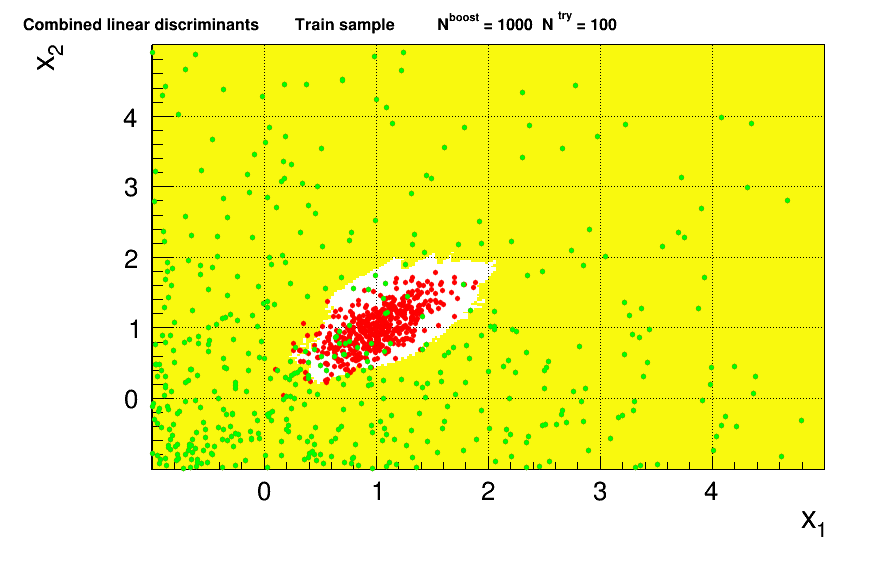

Info in <TCanvas::Print>: png file 12_Boost5_0.7_1000_100_train.png has been created


In [9]:
# Plot 

nbhist.SetTitle("Combined linear discriminants        Train sample    ^{ }N^{boost} = "
                  +str(Nboost)+"  N^{try} = "+str(Ntry))
nbhist.Draw("COL")

tgr.Draw('P')
tgr1.Draw('P')

cexp.Update()

fname = '12_Boost5_'+str(corr2)+'_'+str(Nboost)+'_'+str(Ntry)+'_train.png'
    
cexp.Print(fname)

Image(filename=fname)

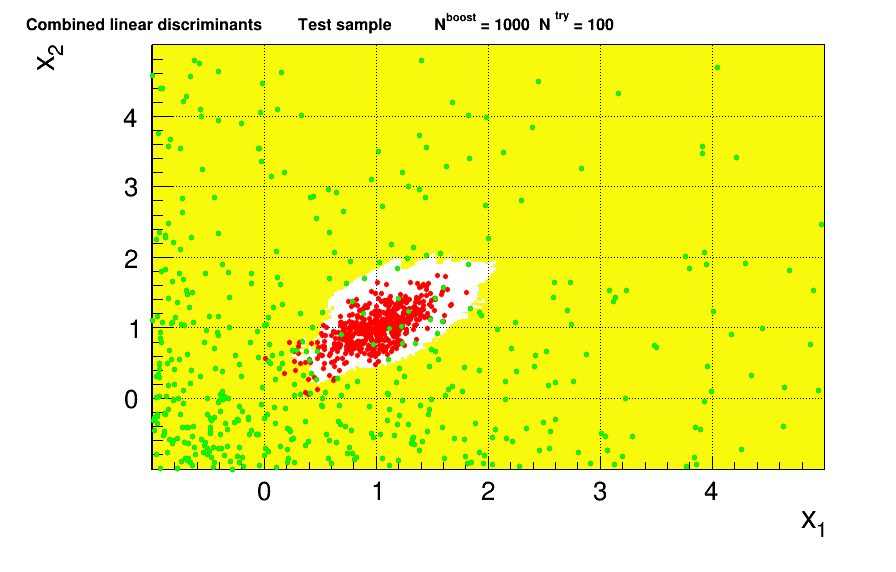

Info in <TCanvas::Print>: png file 12_Boost4_0.7_1000_100_test.png has been created


In [10]:
# Plot 

nbhist.SetTitle("Combined linear discriminants        Test sample    ^{ }N^{boost} = "
                  +str(Nboost)+"  N^{try} = "+str(Ntry))
nbhist.Draw("COL")

rgr.Draw('P')
rgr1.Draw('P')

cexp.Update()

fname = '12_Boost4_'+str(corr2)+'_'+str(Nboost)+'_'+str(Ntry)+'_test.png'
    
cexp.Print(fname)

Image(filename=fname)